In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!echo "{\"username\":\"negarbam\",\"key\":\"3532c11c5089e999d1311b49e01fe848\"}" > kaggle.json
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c g-research-crypto-forecasting

 99%|██████████████████████████████████████▍| 1.12G/1.13G [00:09<00:00, 146MB/s]
100%|███████████████████████████████████████| 1.13G/1.13G [00:10<00:00, 119MB/s]


In [4]:
!unzip -q g-research-crypto-forecasting.zip

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Input, BatchNormalization
import sklearn
from sklearn import preprocessing
from collections import deque
from keras.callbacks import LearningRateScheduler

tf.config.optimizer.set_jit(True)

2024-03-27 17:59:40.513874: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 17:59:40.513987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 17:59:40.670484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Dataset

Read data and display the first few rows:

In [6]:
df = pd.read_csv("train.csv")
df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


### Handle missing values

Fill gaps with previous values, drop remaining NaN rows.


In [7]:
df.fillna(method="ffill", inplace=True) 
df.dropna(inplace=True)
print(df.head())

/tmp/ipykernel_34/2118209106.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known va


    timestamp  Asset_ID  Count        Open        High         Low  \
0  1514764860         2   40.0   2376.5800   2399.5000   2357.1400   
1  1514764860         0    5.0      8.5300      8.5300      8.5300   
2  1514764860         1  229.0  13835.1940  14013.8000  13666.1100   
3  1514764860         5   32.0      7.6596      7.6596      7.6567   
4  1514764860         7    5.0     25.9200     25.9200     25.8740   

        Close       Volume          VWAP    Target  
0   2374.5900    19.233005   2373.116392 -0.004218  
1      8.5300    78.380000      8.530000 -0.014399  
2  13850.1760    31.550062  13827.062093 -0.014643  
3      7.6576  6626.713370      7.657713 -0.013922  
4     25.8770   121.087310     25.891363 -0.008264  


### Combining Cryptocurrency Data

The code combines Close and Volume data from multiple cryptocurrencies into a single DataFrame total_df. It iterates through each cryptocurrency, extracts its data from the original DataFrame df, and renames the columns accordingly. The resulting DataFrame provides a consolidated view of cryptocurrency prices and trading volumes.

In [8]:
cryptoasset = {0:'BinanceCoin', 1: 'Bitcoin', 2: 'BitcoinCash',6: 'Ethereum', 9:'Litecoin', 12: 'Stellar'}

total_df = None
for k, v in cryptoasset.items():
    df_k = df[df['Asset_ID'] == k].copy()
    df_k = df_k.set_index('timestamp')
    df_k = df_k[['Close', 'Volume']]
    df_k = df_k.rename(columns={'Close':f'{v}_Close', 'Volume':f'{v}_Volume'})
    if total_df is None:
        total_df = df_k
    else:
        total_df = total_df.join(df_k)

total_df = total_df.dropna()
total_df.head()

,BinanceCoin_Close,BinanceCoin_Volume,Bitcoin_Close,Bitcoin_Volume,BitcoinCash_Close,BitcoinCash_Volume,Ethereum_Close,Ethereum_Volume,Litecoin_Close,Litecoin_Volume,Stellar_Close,Stellar_Volume
timestamp,,,,,,,,,,,,
1518825180,11.0997,1835.03,10174.085000,31.667084,1536.6575,44.913258,938.141667,195.856604,228.368000,299.812032,0.3600,3779.362927
1518826560,10.9492,1230.57,10111.701667,106.155639,1516.6550,26.051699,937.690000,225.937319,227.870000,353.030663,0.4100,800.000000
1518827820,10.9782,3102.75,10128.286667,57.670267,1530.8000,88.803876,937.791667,140.475112,227.760000,1280.406549,0.4700,400.000000
1518828660,11.1294,3942.08,10192.620000,88.384346,1540.5825,79.641522,941.475000,226.612895,228.118000,387.722939,0.4698,450.000000
1518828720,11.1003,3143.50,10172.418333,68.854705,1537.6375,128.027365,940.645000,527.225349,227.618333,1188.342764,0.4500,312.978512


## Create Target column

In [9]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Bitcoin"

### Adding Future Price Data

The code adds a new column future to the DataFrame total_df, representing the future price of a specified cryptocurrency (RATIO_TO_PREDICT). The future price is obtained by shifting the Close price data of the cryptocurrency backward by a specified number of periods (FUTURE_PERIOD_PREDICT). This column is useful for training predictive models that aim to forecast future cryptocurrency prices based on historical data.

In [10]:
total_df['future'] = total_df[f"{RATIO_TO_PREDICT}_Close"].shift(-FUTURE_PERIOD_PREDICT)

In [11]:
total_df.head()

,BinanceCoin_Close,BinanceCoin_Volume,Bitcoin_Close,Bitcoin_Volume,BitcoinCash_Close,BitcoinCash_Volume,Ethereum_Close,Ethereum_Volume,Litecoin_Close,Litecoin_Volume,Stellar_Close,Stellar_Volume,future
timestamp,,,,,,,,,,,,,
1518825180,11.0997,1835.03,10174.085000,31.667084,1536.6575,44.913258,938.141667,195.856604,228.368000,299.812032,0.3600,3779.362927,10192.620000
1518826560,10.9492,1230.57,10111.701667,106.155639,1516.6550,26.051699,937.690000,225.937319,227.870000,353.030663,0.4100,800.000000,10172.418333
1518827820,10.9782,3102.75,10128.286667,57.670267,1530.8000,88.803876,937.791667,140.475112,227.760000,1280.406549,0.4700,400.000000,10179.755000
1518828660,11.1294,3942.08,10192.620000,88.384346,1540.5825,79.641522,941.475000,226.612895,228.118000,387.722939,0.4698,450.000000,10192.063333
1518828720,11.1003,3143.50,10172.418333,68.854705,1537.6375,128.027365,940.645000,527.225349,227.618333,1188.342764,0.4500,312.978512,10206.483333


### Target Labeling Function

The classify function creates binary target labels for cryptocurrency price movements. It assigns 1 if the future price is higher than the current price, and 0 otherwise.

In [12]:
def classify(current, future):
  if future > current:
    return 1
  else: return 0

In [13]:
total_df['target'] = list(map(classify, total_df[f"{RATIO_TO_PREDICT}_Close"], total_df["future"] ))

In [14]:
total_df.head()

,BinanceCoin_Close,BinanceCoin_Volume,Bitcoin_Close,Bitcoin_Volume,BitcoinCash_Close,BitcoinCash_Volume,Ethereum_Close,Ethereum_Volume,Litecoin_Close,Litecoin_Volume,Stellar_Close,Stellar_Volume,future,target
timestamp,,,,,,,,,,,,,,
1518825180,11.0997,1835.03,10174.085000,31.667084,1536.6575,44.913258,938.141667,195.856604,228.368000,299.812032,0.3600,3779.362927,10192.620000,1
1518826560,10.9492,1230.57,10111.701667,106.155639,1516.6550,26.051699,937.690000,225.937319,227.870000,353.030663,0.4100,800.000000,10172.418333,1
1518827820,10.9782,3102.75,10128.286667,57.670267,1530.8000,88.803876,937.791667,140.475112,227.760000,1280.406549,0.4700,400.000000,10179.755000,1
1518828660,11.1294,3942.08,10192.620000,88.384346,1540.5825,79.641522,941.475000,226.612895,228.118000,387.722939,0.4698,450.000000,10192.063333,0
1518828720,11.1003,3143.50,10172.418333,68.854705,1537.6375,128.027365,940.645000,527.225349,227.618333,1188.342764,0.4500,312.978512,10206.483333,1


## DataSet Preprocessing

The preprocess_df function prepares a DataFrame for training predictive models by performing the following steps:

1.Dropping the 'future' column, we don't need it.

2.Scaling numerical features by computing their percentage change and applying z-score normalization.

3.Handling infinite values (inf) by replacing them with NaN and dropping corresponding rows.

4.Limiting the DataFrame to a maximum of 100,000 rows.

This function ensures that the data is properly preprocessed and ready for training.

In [15]:
def preprocess_df(df):
   df = df.drop(labels=['future'], axis=1)

   for col in df.columns:
        if col != 'target':
            df[col] = df[col].pct_change()
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)
   df.dropna(inplace=True)
   return df.iloc[:100000]

In [16]:
df = preprocess_df(total_df)

## Data Splitting for Training and Validation

The provided code splits the DataFrame df into training and validation sets based on the specified VALIDATION_SPLIT ratio. It sorts the DataFrame indices (timestamps), divides them into training and validation sets, and then selects the corresponding data from df.

In [17]:
VALIDATION_SPLIT = 0.4
timestamps = sorted(df.index.values)
total = len(timestamps)
training_timestamps = timestamps[:int((1 - VALIDATION_SPLIT) * total)]
validation_timestamps = timestamps[int((1 - VALIDATION_SPLIT) * total):]

training_df = df.loc[training_timestamps]
validation_df = df.loc[validation_timestamps]

training_df.head(30)

,BinanceCoin_Close,BinanceCoin_Volume,Bitcoin_Close,Bitcoin_Volume,BitcoinCash_Close,BitcoinCash_Volume,Ethereum_Close,Ethereum_Volume,Litecoin_Close,Litecoin_Volume,Stellar_Close,Stellar_Volume,target
timestamp,,,,,,,,,,,,,
1518830340,-1.373851,-0.014319,0.033266,-0.591325,0.085877,-0.001912,0.232190,-0.011266,-0.291029,-0.003430,8.134552,-0.001103,1
1518831000,5.933369,-0.011594,0.242001,-0.541286,-0.758876,-0.001945,0.455833,-0.003665,-0.499498,-0.008237,-16.259337,-0.001216,1
1518831840,2.804895,-0.013950,8.486247,3.246321,0.592089,-0.001792,2.965785,0.070876,7.795989,0.001745,-0.001172,-0.001214,1
1518832020,3.068966,-0.013704,1.122803,-0.598532,0.365421,-0.001922,0.580371,-0.010779,-0.115284,-0.009807,-0.001172,-0.001215,0
1518832260,3.672527,-0.010278,-0.395842,-0.315286,-0.627467,-0.001935,-0.200191,-0.004850,-0.528962,-0.009070,16.963268,-0.001198,1
1518832320,-0.296860,-0.014313,-0.450750,-0.414877,0.216109,-0.001543,-0.089094,-0.007077,0.049533,-0.011469,-0.001172,-0.001216,1
1518832500,2.652910,-0.013885,-0.526061,1.061381,-0.233309,-0.001950,0.044308,0.002872,0.514097,-0.009571,-16.339034,-0.001214,1
1518833100,8.210678,-0.012802,6.161656,0.516434,0.816964,-0.001921,1.312712,-0.007550,0.930511,-0.002708,-16.220634,-0.001214,1
1518833520,-10.348889,-0.013441,-0.013072,-0.399162,-0.233156,-0.001879,-0.131167,-0.006580,-2.363637,-0.008432,-4.340225,-0.001215,1


### Data Conversion Function

The convertToDataSet function converts the DataFrame df into sequential data suitable for training recurrent neural networks (RNNs). It creates sequences of length SEQ_LEN by sliding a deque window over the DataFrame rows. Each sequence consists of input features (X) and a corresponding target (y). The function shuffles the sequential data and returns the input sequences X and their corresponding targets y, reshaped to ensure compatibility with RNN input requirements.

In [37]:
def convertToDataSet(df):
    de_list = deque(maxlen=SEQ_LEN)
    sequential_data = []
    X = []
    y = []
    for item in df.values:
        de_list.append([n for n in item[:-1]])
        if len(de_list) == SEQ_LEN:
            sequential_data.append([np.array(de_list), item[-1]])

    np.random.shuffle(sequential_data)
    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)

    return np.array(X), np.array(y).reshape((-1, 1))

In [38]:
X, labels = convertToDataSet(df)
X_train, y_train = convertToDataSet(training_df)
X_val, y_val = convertToDataSet(validation_df)

In [40]:
y_train.shape

(59941, 1)

In [42]:
y_val.shape

(39941, 1)

## Neural Network Architecture

**LSTM (Long Short-Term Memory)**

LSTM networks are pivotal in cryptocurrency price prediction, adept at analyzing historical data and forecasting future trends. Unlike traditional RNNs, LSTM networks excel in handling sequential data with long-term dependencies. By selectively retaining and updating information over time, LSTM networks capture intricate patterns in cryptocurrency price sequences.

In this task, LSTM layers process sequential cryptocurrency price data, enabling the model to learn from past price movements and predict future changes. Leveraging memory cells and recurrent connections, the model analyzes temporal dependencies and adjusts predictions based on historical price trends.


In [118]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(Dropout(0.35))
model.add(BatchNormalization())

model.add(LSTM(units=128, input_shape=(X_train.shape[1:])))
model.add(Dropout(0.35))
model.add(BatchNormalization())

model.add(Dense(32))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [119]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

initial_lr = 0.001
def scheduler(epoch):
    return initial_lr * 0.75 ** epoch

learningRateScheduler = LearningRateScheduler(scheduler)

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

### Model Training



In [120]:
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks = [learningRateScheduler])

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.5019 - loss: 0.8504 - val_accuracy: 0.5088 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5176 - loss: 0.7022 - val_accuracy: 0.5163 - val_loss: 0.6916 - learning_rate: 7.5000e-04
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5322 - loss: 0.6911 - val_accuracy: 0.5275 - val_loss: 0.6909 - learning_rate: 5.6250e-04
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5417 - loss: 0.6882 - val_accuracy: 0.5368 - val_loss: 0.6891 - learning_rate: 4.2188e-04
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5505 - loss: 0.6860 - val_accuracy: 0.5395 - val_loss: 0.6887 - learning_rate: 3.1641e-04
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5523 - loss: 0.6852 - val_accuracy: 0.5397 - val_loss: 0.6887 - learning_rate: 2.3730e-04
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accur

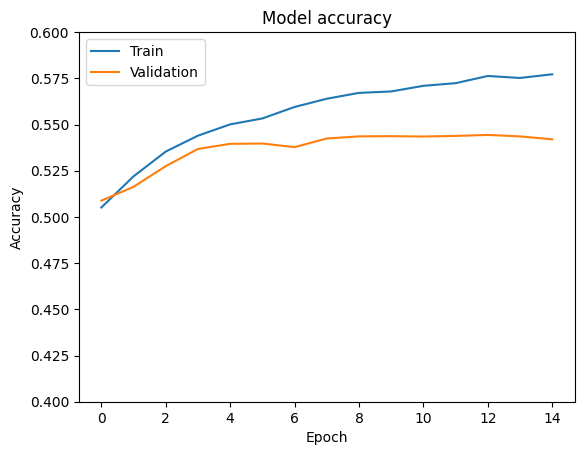

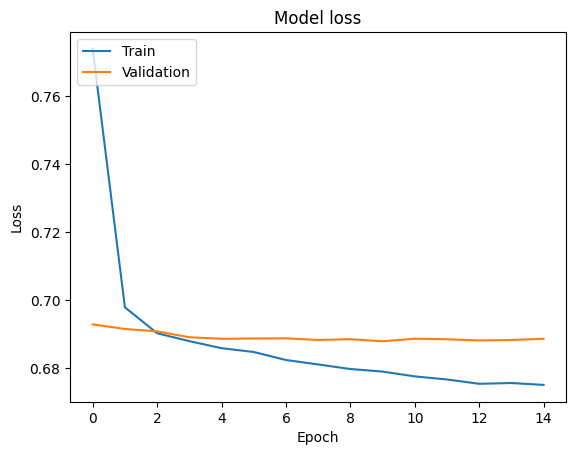

In [131]:


# Assuming `history` is the object returned by model.fit()
# It typically contains loss and metrics values for each epoch
# You can access them as `history.history['loss']` and `history.history['val_loss']`
# if you're interested in the loss values.

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
ax = plt.gca()
ax.set_ylim([0.4, 0.6])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()